# Training
Este notebook inspirado en el colab anterior esta hecho para poder realizar entrenamiento simple

In [12]:
# !cd ../data && wget https://descargas.inf.santiago.usm.cl/train/6.tar.gz .

In [13]:
# !tar -xf ../data/6.tar.gz -C ../data

In [14]:
#!pip install scikit-optimize

# Codigo de Optimizacion
Definimos los parametros a modificar para realizar proceso de optimizacion

In [15]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import CheckpointSaver

from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D

from skopt.utils import use_named_args

# guardar informacion
import pickle
import os




# Codigo

In [16]:
import datetime

import matplotlib.pyplot as plt
from grav_lens import load_tf_dataset, get_datasets

import numpy as np
import tensorflow as tf

#data
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
# training and modeling
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D


def plot_images(images, cls_true, cls_pred=None, **kwargs):
    assert len(images) == len(cls_true) == 9
    img_shape = images[0].shape
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()



In [17]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split


# Ejemplo de uso
train_dataset, val_dataset, test_dataset = get_datasets(data_index='6', max_files=100, home='..')

for X, Y in train_dataset.take(1):  # Mostrar un batch de entrenamiento
    print("Train X:", X.shape)
    print("Train Y:", Y.shape)

for X, Y in val_dataset.take(1):  # Mostrar un batch de validación
    print("Val X:", X.shape)
    print("Val Y:", Y.shape)

for X, Y in test_dataset.take(1):  # Mostrar un batch de prueba
    print("Test X:", X.shape)
    print("Test Y:", Y.shape)


Using data folder: ../data/6
Train X: (32, 128, 128, 3)
Train Y: (32, 128, 128, 1)
Val X: (20, 128, 128, 3)
Val Y: (20, 128, 128, 1)
Test X: (11, 128, 128, 3)
Test Y: (11, 128, 128, 1)


2024-08-14 12:24:37.444397: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
import tensorflow as tf

def combined_loss(weight_kl=0.1):
    def loss(y_true, y_pred):
        mae_loss = tf.keras.losses.mae(y_true, y_pred)
        kl_loss = tf.keras.losses.kld(y_true, y_pred)
        return mae_loss + weight_kl * kl_loss
    return loss

def create_model(learning_rate=1e-4, 
                 in_activation="sigmoid",
                 h_activation="sigmoid", 
                 out_activation="sigmoid",
                 h_kernel_size=3, 
                 hidden_filters=64,
                 out_kernel_size=3,
                 weight_kl=0.1,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=1e-7,
                 amsgrad=False,
                 decay_steps=10000,
                 decay_rate=0.96
                 ):
    """
    Modelo que agranda las dimensiones espaciales hasta 256x256 y luego las reduce a 128x128.
    
    Hyper-parameters:
        learning_rate:     Tasa de aprendizaje inicial.
        in_activation:     Función de activación para la capa de entrada.
        h_activation:      Función de activación para las capas ocultas.
        out_activation:    Función de activación para la capa de salida.
        h_kernel_size:     Tamaño del kernel para las capas de convolución ocultas.
        hidden_filters:    Número de filtros en las capas de convolución ocultas.
        out_kernel_size:   Tamaño del kernel para la capa de salida.
        weight_kl:         Peso de la pérdida KL Divergence en la función de pérdida combinada.
        beta_1:            Coeficiente de decaimiento exponencial para el primer momento.
        beta_2:            Coeficiente de decaimiento exponencial para el segundo momento.
        epsilon:           Valor pequeño para evitar división por cero.
        amsgrad:           Booleano para usar la variante AMSGrad del optimizador Adam.
        decay_steps:       Valor de caida del learning rate con el scheduler exponencial
        decay_rate:        Ratio de caide del scheduler
    """
    model = tf.keras.models.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=(128, 128, 3)),

        # Aumentar dimensiones a 256x256
        tf.keras.layers.Conv2D(32, (3, 3), activation=in_activation, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.UpSampling2D(size=(2, 2)),  # 128x128 -> 256x256
        
        # Mantener 256x256 con mayor profundidad
        tf.keras.layers.Conv2D(hidden_filters, (h_kernel_size, h_kernel_size), activation=h_activation, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(2 * hidden_filters, (h_kernel_size, h_kernel_size), activation=h_activation, padding='same'),
        tf.keras.layers.BatchNormalization(),

        # Reducir de vuelta a 128x128
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # 256x256 -> 128x128
        tf.keras.layers.Conv2D(64, (3, 3), activation=h_activation, padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        # Salida con 1 canal
        tf.keras.layers.Conv2D(1, (out_kernel_size, out_kernel_size), activation=out_activation, padding='same')
    ])

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=learning_rate,
      decay_steps=decay_steps,
      decay_rate=decay_rate,
      staircase=True)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, 
                                         beta_1=beta_1, 
                                         beta_2=beta_2, 
                                         epsilon=epsilon, 
                                         amsgrad=amsgrad)

    model.compile(optimizer=optimizer, loss=combined_loss(weight_kl))

    return model


def load_hyperparameters(counter):
    with open(f'hyperparameters_{counter}.json', 'r') as f:
        hyperparameters = json.load(f)
    return hyperparameters

def load_model_with_hyperparameters(counter):
    # Cargar los hiperparámetros
    hyperparameters = load_hyperparameters(counter)
    learning_rate = hyperparameters['learning_rate']
    activation = hyperparameters['activation']

    # Recrear el modelo con los hiperparámetros cargados
    model = create_model(learning_rate, activation)
    
    # Cargar los pesos del modelo
    model.load_weights(f'best_model_{counter}.weights.h5')

    return model

# Crear el modelo
model = create_model()
model.summary()




Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256, 256, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,769 (659.25 KB)

 Trainable params: 168,193 (657.00 KB)

 Non-trainable params: 576 (2.25 KB)

## Visualizacion del modelo

In [19]:
import visualkeras

# visualkeras.layered_view(model, legend=True, show_dimension=True,draw_volume=True,
#                           scale_xy=1, scale_z=1)

## Training Hiperparameter

In [20]:
import datetime
import json

def log_dir_name(learning_rate, in_activation, h_activation, out_activation, 
                 h_kernel_size, hidden_filters, out_kernel_size, weight_kl, 
                 beta_1, beta_2, epsilon, amsgrad, decay_steps, decay_rate):
    """
    Helper function para generar el nombre del directorio de TensorBoard.

    Args:
        learning_rate (float): Tasa de aprendizaje para el optimizador.
        in_activation (str): Función de activación para la capa de entrada.
        h_activation (str): Función de activación para las capas ocultas.
        out_activation (str): Función de activación para la capa de salida.
        h_kernel_size (int): Tamaño del kernel para capas ocultas.
        hidden_filters (int): Número de filtros en las capas ocultas.
        out_kernel_size (int): Tamaño del kernel para la capa de salida.
        weight_kl (float): Peso para KL Divergence en la pérdida.
        beta_1 (float): Parámetro beta_1 para el optimizador Adam.
        beta_2 (float): Parámetro beta_2 para el optimizador Adam.
        epsilon (float): Parámetro epsilon para el optimizador Adam.
        amsgrad (bool): Usar AMSGrad en el optimizador Adam.
        decay_steps (int): Número de pasos para el decaimiento del learning rate.
        decay_rate (float): Tasa de decaimiento para el learning rate.

    Returns:
        str: Ruta del directorio para TensorBoard.
    """
    s = "./logs/lr_{0:.0e}_inact_{1}_hact_{2}_outact_{3}_hks_{4}_hf_{5}_oks_{6}_wkl_{7}_beta1_{8}_beta2_{9}_eps_{10}_amsgrad_{11}_decaysteps_{12}_decayrate_{13}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    log_dir = s.format(learning_rate, 
                       in_activation,
                       h_activation,
                       out_activation,
                       h_kernel_size,
                       hidden_filters,
                       out_kernel_size,
                       weight_kl,
                       beta_1,
                       beta_2,
                       epsilon,
                       amsgrad,
                       decay_steps,
                       decay_rate)

    return log_dir

def save_hyperparameters(learning_rate, in_activation, h_activation, out_activation, 
                         h_kernel_size, hidden_filters, out_kernel_size, weight_kl, 
                         beta_1, beta_2, epsilon, amsgrad, decay_steps, decay_rate, counter):
    """
    Guarda los hiperparámetros en un archivo JSON.

    Args:
        learning_rate (float): Tasa de aprendizaje para el optimizador.
        in_activation (str): Función de activación para la capa de entrada.
        h_activation (str): Función de activación para las capas ocultas.
        out_activation (str): Función de activación para la capa de salida.
        h_kernel_size (int): Tamaño del kernel para capas ocultas.
        hidden_filters (int): Número de filtros en las capas ocultas.
        out_kernel_size (int): Tamaño del kernel para la capa de salida.
        weight_kl (float): Peso para KL Divergence en la pérdida.
        beta_1 (float): Parámetro beta_1 para el optimizador Adam.
        beta_2 (float): Parámetro beta_2 para el optimizador Adam.
        epsilon (float): Parámetro epsilon para el optimizador Adam.
        amsgrad (bool): Usar AMSGrad en el optimizador Adam.
        decay_steps (int): Número de pasos para el decaimiento del learning rate.
        decay_rate (float): Tasa de decaimiento para el learning rate.
        counter (int): Identificador para el archivo de guardado.

    Returns:
        None
    """
    hyperparameters = {
        'learning_rate': learning_rate,
        'in_activation': in_activation,
        'h_activation': h_activation,
        'out_activation': out_activation,
        'h_kernel_size': h_kernel_size,
        'hidden_filters': hidden_filters,
        'out_kernel_size': out_kernel_size,
        'weight_kl': weight_kl,
        'beta_1': beta_1,
        'beta_2': beta_2,
        'epsilon': epsilon,
        'amsgrad': amsgrad,
        'decay_steps': decay_steps,
        'decay_rate': decay_rate
    }
    
    with open(f'hyperparameters_{counter}.json', 'w') as f:
        json.dump(hyperparameters, f, indent=4)


In [25]:
# Definir las dimensiones de los hiperparámetros para la optimización
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate')
dim_in_activation = Categorical(categories=['relu', 'sigmoid', 'tanh'], name='in_activation')
dim_h_activation = Categorical(categories=['relu', 'sigmoid', 'tanh'], name='h_activation')
dim_out_activation = Categorical(categories=['relu', 'sigmoid', 'tanh'], name='out_activation')

dim_h_kernel_size = Integer(low=2, high=7, name='h_kernel_size')  # Tamaño del kernel para capas ocultas
dim_hidden_filters = Integer(low=16, high=128, name='hidden_filters')  # Número de filtros en capas ocultas
dim_out_kernel_size = Integer(low=2, high=7, name='out_kernel_size')  # Tamaño del kernel para la capa de salida

dim_weight_kl = Real(low=0.01, high=2.0, prior='log-uniform', name='weight_kl')  # Peso para KL Divergence en la pérdida
dim_beta_1 = Real(low=0.0, high=0.99, name='beta_1')  # Parámetro beta_1 para el optimizador Adam
dim_beta_2 = Real(low=0.0, high=0.999, name='beta_2')  # Parámetro beta_2 para el optimizador Adam

dim_epsilon = Real(low=1e-8, high=1e-4, prior='log-uniform', name='epsilon')  # Parámetro epsilon para el optimizador Adam
dim_amsgrad = Categorical(categories=[True, False], name='amsgrad')  # Usar AMSGrad o no
dim_decay_steps = Integer(low=1000, high=50000, name='decay_steps')  # Número de pasos para el decaimiento del learning rate

dim_decay_rate = Real(low=0.8, high=0.99, name='decay_rate')  # Tasa de decaimiento para el learning rate
dim_epochs = Integer(low=5, high=25, name='epochs')  # Número de épocas para entrenamiento

# Lista de todas las dimensiones
dimensions = [
    dim_learning_rate, dim_in_activation, 
    dim_h_activation, dim_out_activation,
    dim_h_kernel_size, dim_hidden_filters, dim_out_kernel_size,
    dim_weight_kl, dim_beta_1, dim_beta_2,
    dim_epsilon, dim_amsgrad, dim_decay_steps, 
    dim_decay_rate, dim_epochs
]

# Nombres de las dimensiones para referencia
dimension_names = [x.name for x in dimensions]

# Valores predeterminados para los hiperparámetros
default_parameters = [1e-4, 'sigmoid', 
                      'sigmoid', 'sigmoid', 
                      3, 64, 3, 
                      0.1, 0.9, 0.99, 
                      1e-7, False, 10000, 
                      0.96, 10]


In [ ]:
import time
# Inicializar best_accuracy
best_loss = float('inf')
verbose = 1
counter = 1

# Función objetivo
@use_named_args(dimensions=dimensions)
def F_objective(learning_rate, 
                in_activation, h_activation, out_activation, 
                h_kernel_size, hidden_filters, 
                out_kernel_size, weight_kl, 
                beta_1, beta_2, epsilon, amsgrad, 
                decay_steps, decay_rate, epochs):
    """
    Función objetivo para la optimización de hiperparámetros.
    
    Hyper-parameters:
        - learning_rate (float): La tasa de aprendizaje para el optimizador Adam, que controla 
          la magnitud de las actualizaciones de los pesos durante el entrenamiento.
        - in_activation (str): La función de activación utilizada en la primera capa convolucional.
        - h_activation (str): La función de activación utilizada en las capas convolucionales ocultas 
          que procesan la imagen a tamaño 256x256 y nuevamente después de reducirla a 128x128.
        - out_activation (str): La función de activación utilizada en la capa de salida que produce la 
          imagen final con una sola capa de canal.
        - h_kernel_size (int): El tamaño del kernel para las capas convolucionales ocultas, que determina 
          el tamaño del filtro utilizado para convolucionar la imagen.
        - hidden_filters (int): El número de filtros en las capas convolucionales ocultas, lo que determina 
          la profundidad de la salida de la convolución.
        - out_kernel_size (int): El tamaño del kernel para la capa convolucional de salida, que define cómo 
          se combina la información para producir la imagen final.
        - weight_kl (float): Un factor de ponderación para la pérdida de KL Divergence cuando se combina 
          con la pérdida de MAE. Esto ajusta la influencia de KL Divergence en la función de pérdida final.
        - beta_1 (float): Parámetro beta_1 para el optimizador Adam, que controla el momento de primer orden.
        - beta_2 (float): Parámetro beta_2 para el optimizador Adam, que controla el momento de segundo orden.
        - epsilon (float): Parámetro epsilon para el optimizador Adam, que previene divisiones por cero.
        - amsgrad (bool): Indica si se debe usar el algoritmo AMSGrad en el optimizador Adam.
        - decay_steps (int): Número de pasos para el decaimiento del learning rate.
        - decay_rate (float): Tasa de decaimiento para el learning rate.
        - epochs (int): La cantidad de épocas para las que se entrena el modelo.
    """
    # Crear el modelo
    model = create_model(learning_rate, 
                 in_activation,
                 h_activation, 
                 out_activation,
                 h_kernel_size, 
                 hidden_filters,
                 out_kernel_size,
                 weight_kl,
                 beta_1,
                 beta_2,
                 epsilon,
                 amsgrad,
                 decay_steps,
                 decay_rate
                 )


    # Generar el nombre del directorio de TensorBoard
    log_dir = log_dir_name(
        learning_rate, 
        in_activation, 
        h_activation, 
        out_activation, 
        h_kernel_size, 
        hidden_filters, 
        out_kernel_size, 
        weight_kl, 
        beta_1, 
        beta_2, 
        epsilon, 
        amsgrad, 
        decay_steps, 
        decay_rate
    )
    tensorboard_callback = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True)


    # Entrenar el modelo con TensorBoard callback
    model.fit(train_dataset, epochs=epochs, verbose=verbose, callbacks=[tensorboard_callback])

    loss = model.evaluate(val_dataset, verbose=0)


    # Print the classification accuracy.
    print()
    print("loss: {0:.2%}".format(loss))
    print()

    # Guardamos la mejor precision
    global best_loss, counter

    if loss < best_loss:
        # Salvar el modelo
        model.save_weights(f'best_model_{counter}.weights.h5')

        # Guardar hiperparámetros
        save_hyperparameters(
            learning_rate, in_activation, h_activation, 
            out_activation, h_kernel_size, hidden_filters, 
            out_kernel_size, weight_kl, 
            beta_1, beta_2, epsilon, 
            amsgrad, decay_steps, decay_rate, 
            counter
        )

        print(f"Model weights and hyperparameters saved with ID: {counter}")
        print(f"TensorBoard logs directory: {log_dir}")

        # Incrementar el contador
        counter += 1

        # Actualizar la mejor pérdida
        best_loss = loss

        
    # Borrar el modelo y los hiperparametro de memoria
    del model
    # y reiniciar el grafo computacional
    K.clear_session()
    return loss  # Queremos maximizar la precisión, por lo que minimizamos -precisión

# Comprobar funcionamiento
start_time = time.time()
F_objective(x=default_parameters)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Execution time: {execution_time_minutes:.2f} minutes")

: 

# GRAN MINIMIZACION

Codigo de minimizacion
Posiblemente tome bastante tiempo en ejecutarse

In [ ]:
train_dataset, val_dataset, test_dataset = get_datasets(data_index=6, max_files=1500, home='..')

Using data folder: ../data/6


In [ ]:
# Crear un callback para guardar checkpoints
checkpoint_saver = CheckpointSaver("checkpoint.pkl", compress=9)

# Ejecutar la optimizacion
start_time = time.time()
res = gp_minimize(func=F_objective,
                    dimensions=dimensions,
                    acq_func='EI', # Expected Improvement.
                    n_calls=31,
                    x0=default_parameters,
                    callback=[checkpoint_saver])
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Execution time: {execution_time_minutes:.2f} minutes")

In [ ]:

# Guardar el objeto res, para hacer estadistica despues
with open('optimization_results.pkl', 'wb') as f:
    pickle.dump(res, f)

# Hacer un plot
Veamos que tal lo ha hecho el modelo

Space([Real(low=1e-06, high=0.01, prior='log-uniform', transform='normalize'),
       Categorical(categories=('relu', 'sigmoid', 'tanh'), prior=None)])
[0.003636525599163243, 'sigmoid']
Accuracy:  -0.03442706912755966


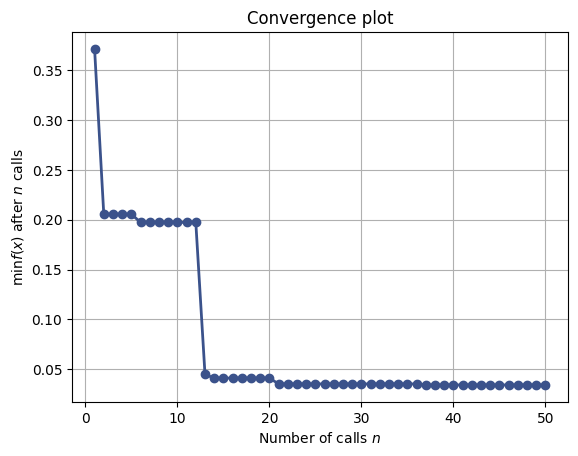

In [ ]:
plot_convergence(res)
print(res.space)
print(res.x)
print("Accuracy: ", - res.fun)

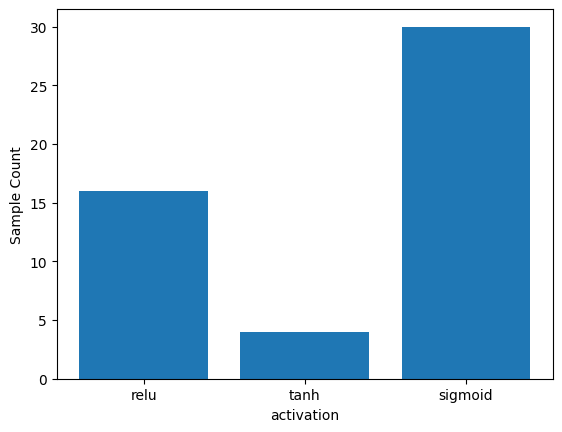

In [ ]:
from skopt.plots import plot_histogram, plot_objective_2D

plot_histogram(result=res,  dimension_identifier='activation')
plt.show()

<Axes: >

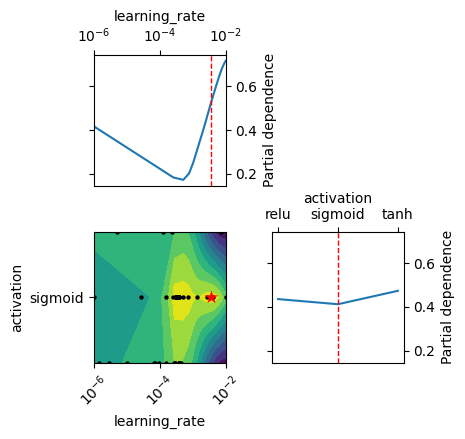

In [ ]:
plot_objective(result=res, dimensions=dimension_names)

<Axes: >

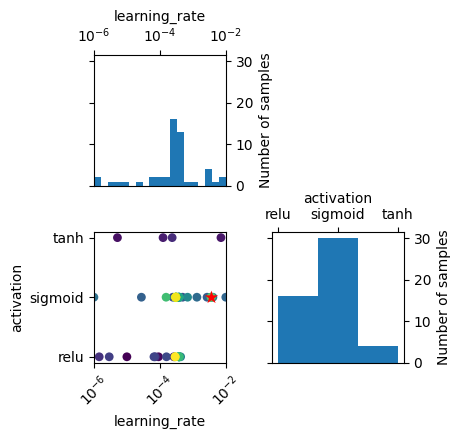

In [ ]:
plot_evaluations(result=res, dimensions=dimension_names)

# Testing Modelo


In [ ]:
# Obtener la primera imagen de la predicción
model = load_model_with_hyperparameters(1)

for X, Y in test_dataset.take(1):
    prediction = model.predict(X)
    
prediction.shape
predicted_images = prediction

# Configurar la figura
fig, axes = plt.subplots(1, predicted_images.shape[0], figsize=(20, 10))
axes = axes.flatten()

# Graficar cada imagen
for img, ax in zip(predicted_images, axes):
    ax.imshow(np.squeeze(img))  # Quitar el canal de color si es necesario
    ax.axis('off')

plt.show()